In [1]:
import logging
import tensorflow as tf


from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc
from env import Env


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = (f'{Env.PROJECT_ROOT}/data/03_processed/daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
    },
    'data': {
        'test_size': 0.1,
    },

    'model_name': 'MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15',
}

2023-10-10 22:25:01.666589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 22:25:01.666637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 22:25:01.666661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 22:25:01.672756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

df_test_X = df_test.drop(columns=['Adj Close'])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test['Adj Close']

#------------------------Load the model if necessary--------------------------
model_scaler_name = config['model_name']

model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)

2023-10-10 22:25:04 - src.data.get_data - INFO - Loaded "../p7-trading-bot/data/03_processed/daily_full". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"
2023-10-10 22:25:04 - __main__ - INFO - df.shape: (5994, 3)
2023-10-10 22:25:04 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')
2023-10-10 22:25:04 - __main__ - INFO - df_train.shape: (5395, 3), df_test.shape: (599, 3)


2023-10-10 22:25:04.632074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 22:25:04.635989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 22:25:04.636022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 22:25:04.637022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 22:25:04.637054: I tensorflow/compile

2023-10-10 22:25:07.789261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


580/580 [==============================] - 5s 5ms/step


2023-10-10 22:25:10.997602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13820549896434940161
2023-10-10 22:25:11 - src.common.plots - INFO - Plot "Predictions MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15-MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15.png" saved to "/workspaces/p7-trading-bot/figures/Predictions MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15-MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15.png"


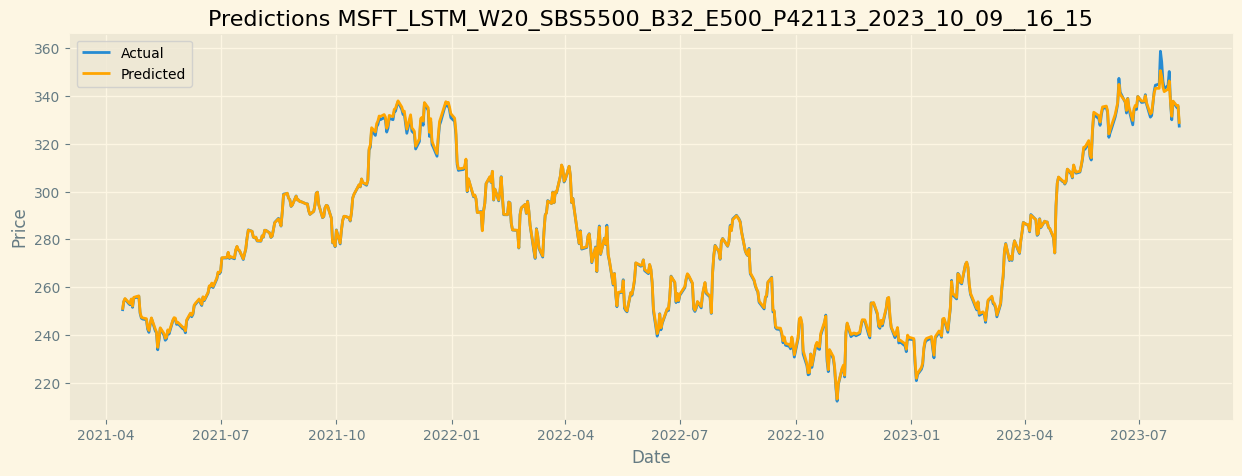

In [3]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers_X,
                                        verbose=False)

df_test_plot_y = TFModelService.prep_test_df_shape(df_test_y, window_size)

V.plot_series(  x=df_test_plot_y.index,  # as dates
                y=(df_test_plot_y, results),
                model_name=model._name,
                title=f'Predictions {model._name}',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=True,)

In [4]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_plot_y.index] # Getting same days as results
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_plot_y, results, naive_forecast)
ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-10-10 22:25:11 - src.models_service.errors - INFO - Test RMSE: $ 0.788
2023-10-10 22:25:11 - src.models_service.errors - INFO - Test MAE : $ 0.52
2023-10-10 22:25:11 - src.models_service.errors - INFO - Test MAPE:   0.002
2023-10-10 22:25:11 - src.models_service.errors - INFO - Test MASE:   0.134
2023-10-10 22:25:11 - src.models_service.errors - INFO - Errors saved to for MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15 model to "logs/models_table.csv" file.


/workspaces/p7-trading-bot/models_trained
MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15.keras
True False
MSFT_LSTM_W20_SBS5500_B32_E500_P42113_2023_10_09__16_15_scalers.pkl
True True
MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.keras
True True
MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04_scalers.pkl
True True
LenearRegression.pkl
True True
